In [138]:
# Vérifier et installer les packages nécessaires
if(require("RPostgres") == FALSE)
utils::install.packages("RPostgres")
library(RPostgres)

if(require("yaml") == FALSE)
utils::install.packages("yaml")
library(yaml)

if(require("ggplot2") == FALSE)
utils::install.packages("ggplot2")
library(ggplot2)

if(require("DBI") == FALSE)
utils::install.packages("DBI")
library(DBI)

if(require("httr") == FALSE)
utils::install.packages("httr")
library(httr)

if(require("dplyr") == FALSE)
utils::install.packages("dplyr")
library(dplyr)

if(require("scales") == FALSE)
utils::install.packages("scales")
library(scales)

if(require("caret") == FALSE)
utils::install.packages("caret")
library(caret)

if(require("rpart") == FALSE)
utils::install.packages("rpart")
library(rpart)

if(require("randomForest") == FALSE)
utils::install.packages("randomForest")
library(randomForest)

if(require("Metrics") == FALSE)
utils::install.packages("Metrics")
library(Metrics)

if(require("tidyr") == FALSE)
utils::install.packages("tidyr")
library(tidyr)


Loading required package: tidyr



In [17]:
# Config file (same as .env)
config <- yaml::read_yaml("config.yml")


host <- config$database$host
port <- config$database$port
dbname <- config$database$dbname
user <- config$database$user
password <- config$database$password

# Connect to Postgres
con <- dbConnect(
  RPostgres::Postgres(),
  host = host,
  port = port,
  dbname = dbname,
  user = user,
  password = password
)

Warning message in readLines(file, warn = readLines.warn):
“incomplete final line found on 'config.yml'”


In [54]:
# Read CSV
file_path <- "/content/Clean_Dataset.csv"
data <- read.csv(file_path)

head(data)

,X,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>
1,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
2,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
3,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
4,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
5,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
6,5,Vistara,UK-945,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.33,1,5955


In [56]:
str(data)

'data.frame':	300153 obs. of  12 variables:
 $ X               : int  0 1 2 3 4 5 6 7 8 9 ...
 $ airline         : chr  "SpiceJet" "SpiceJet" "AirAsia" "Vistara" ...
 $ flight          : chr  "SG-8709" "SG-8157" "I5-764" "UK-995" ...
 $ source_city     : chr  "Delhi" "Delhi" "Delhi" "Delhi" ...
 $ departure_time  : chr  "Evening" "Early_Morning" "Early_Morning" "Morning" ...
 $ stops           : chr  "zero" "zero" "zero" "zero" ...
 $ arrival_time    : chr  "Night" "Morning" "Early_Morning" "Afternoon" ...
 $ destination_city: chr  "Mumbai" "Mumbai" "Mumbai" "Mumbai" ...
 $ class           : chr  "Economy" "Economy" "Economy" "Economy" ...
 $ duration        : num  2.17 2.33 2.17 2.25 2.33 2.33 2.08 2.17 2.17 2.25 ...
 $ days_left       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ price           : int  5953 5953 5956 5955 5955 5955 6060 6060 5954 5954 ...


In [44]:
api_key <- config$database$apikey

In [66]:
flights <- read.csv(file_path)

In [68]:
# Encode columns
flights <- flights %>%
  mutate(
    departure_time_encoded = as.numeric(factor(departure_time, levels = c("Early_Morning", "Morning", "Afternoon", "Evening", "Night", "Late_Night"))),
    arrival_time_encoded  = as.numeric(factor(arrival_time, levels = c("Early_Morning", "Morning", "Afternoon", "Evening", "Night", "Late_Night"))),
    class_encoded  = as.numeric(factor(class, levels = c("Economy", "Business"))),
    airline_encoded  = as.numeric(factor(airline)),
    source_city_encoded  = as.numeric(factor(source_city)),
    destination_city_encoded  = as.numeric(factor(destination_city)),
    stops_encoded  = as.numeric(factor(stops, levels = c("zero", "one", "two_or_more")))
  )
  str(flights)

'data.frame':	300153 obs. of  19 variables:
 $ X                       : int  0 1 2 3 4 5 6 7 8 9 ...
 $ airline                 : chr  "SpiceJet" "SpiceJet" "AirAsia" "Vistara" ...
 $ flight                  : chr  "SG-8709" "SG-8157" "I5-764" "UK-995" ...
 $ source_city             : chr  "Delhi" "Delhi" "Delhi" "Delhi" ...
 $ departure_time          : chr  "Evening" "Early_Morning" "Early_Morning" "Morning" ...
 $ stops                   : chr  "zero" "zero" "zero" "zero" ...
 $ arrival_time            : chr  "Night" "Morning" "Early_Morning" "Afternoon" ...
 $ destination_city        : chr  "Mumbai" "Mumbai" "Mumbai" "Mumbai" ...
 $ class                   : chr  "Economy" "Economy" "Economy" "Economy" ...
 $ duration                : num  2.17 2.33 2.17 2.25 2.33 2.33 2.08 2.17 2.17 2.25 ...
 $ days_left               : int  1 1 1 1 1 1 1 1 1 1 ...
 $ price                   : int  5953 5953 5956 5955 5955 5955 6060 6060 5954 5954 ...
 $ departure_time_encoded  : num  4 1 1 2 2 2 

In [69]:
table_name <- "flights"

# Check response status
if (response$status_code == 200) {
  exchange_rates <- content(response, as = "parsed", simplifyVector = TRUE)

  # Extract the exchange rate value
  conversion_rate <- exchange_rates$conversion_rates$EUR

  if (!is.null(conversion_rate)) {
    print(paste("Conversion rate for EUR:", conversion_rate))

    # Add price_euro
    flights$price_euro <- flights$price * conversion_rate

    # Delete table if exists
    table_exists <- dbExistsTable(con, table_name)
    if (table_exists) {
      dbExecute(con, paste("DELETE FROM", table_name))
    }

    # Insert in DB
    dbWriteTable(con, table_name, flights, row.names = FALSE, overwrite = table_exists)
    print(paste("Data inserted in", table_name))
  } else {
    print("Failed to retrieve conversion rate for EUR.")
  }
} else {
  print(paste("Status code:", response$status_code))
}

[1] "Conversion rate for EUR: 0.011"
[1] "Data inserted in flights"


In [70]:
query <- dbGetQuery(con, "SELECT count(*) FROM flights")
print(query)

   count
1 300153


In [79]:
set.seed(42)  # Specific seed for colours

Don't know how to automatically pick scale for object of type <integer64>.
Defaulting to continuous.


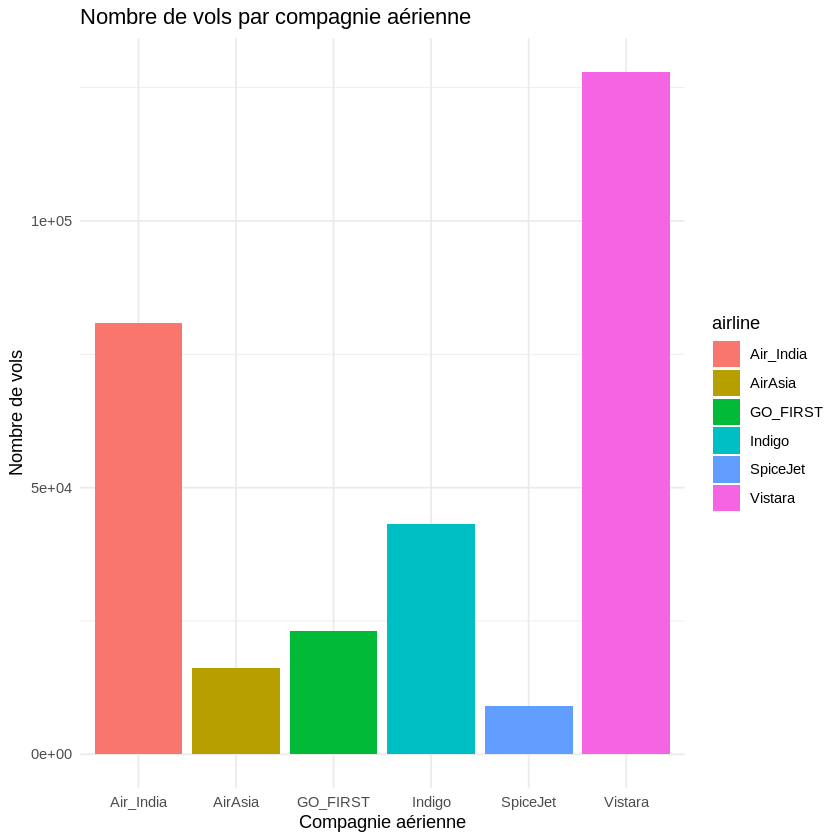

In [82]:
query1 <- "SELECT airline, COUNT(*) AS num_flights FROM flights GROUP BY airline"
data1 <- dbGetQuery(con, query1)

num <- nrow(data1)
random_colors <- hue_pal()(num)


ggplot(data1, aes(x = airline, y = num_flights,fill = airline)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = random_colors) +
  labs(title = "Nombre de vols par compagnie aérienne",
       x = "Compagnie aérienne",
       y = "Nombre de vols") +
  theme_minimal()


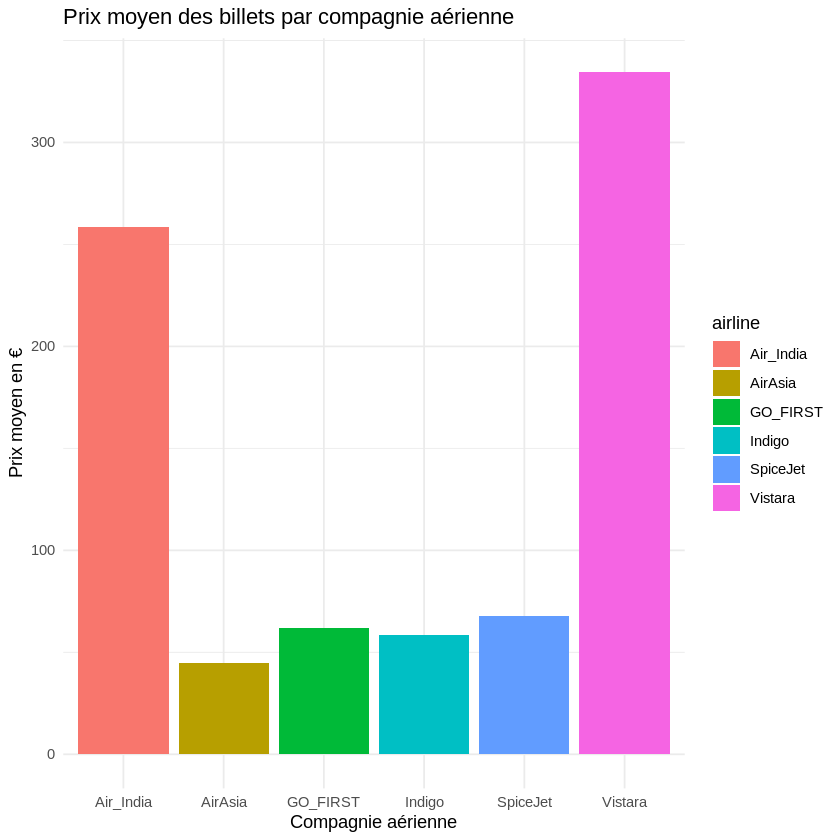

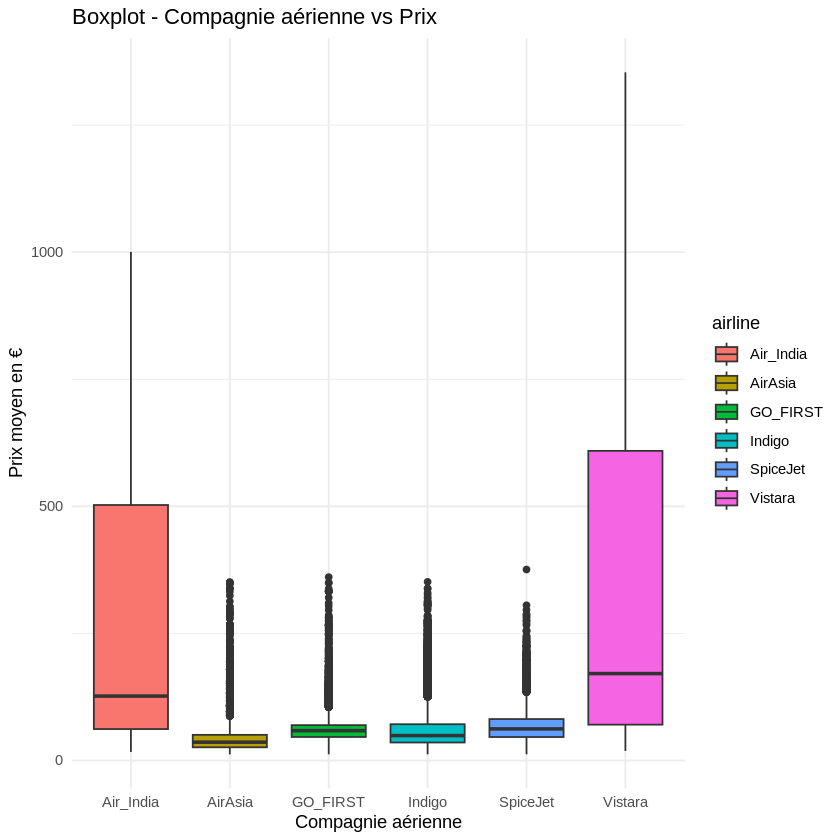

In [103]:
query2 <- "SELECT airline, AVG(price_euro) AS avg_price FROM flights GROUP BY airline"
data2 <- dbGetQuery(con, query2)

num <- nrow(data2)
random_colors <- hue_pal()(num)


ggplot(data2, aes(x = airline, y = avg_price,fill = airline)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = random_colors) +
  labs(title = "Prix moyen des billets par compagnie aérienne",
       x = "Compagnie aérienne",
       y = "Prix moyen en €") +
  theme_minimal()

ggplot(flights, aes(x = airline, y = price_euro,fill = airline)) +
  geom_boxplot() +
  scale_fill_manual(values = random_colors) +
  labs(title = "Boxplot - Compagnie aérienne vs Prix",
       x = "Compagnie aérienne",
       y = "Prix moyen en €") +
  theme_minimal()

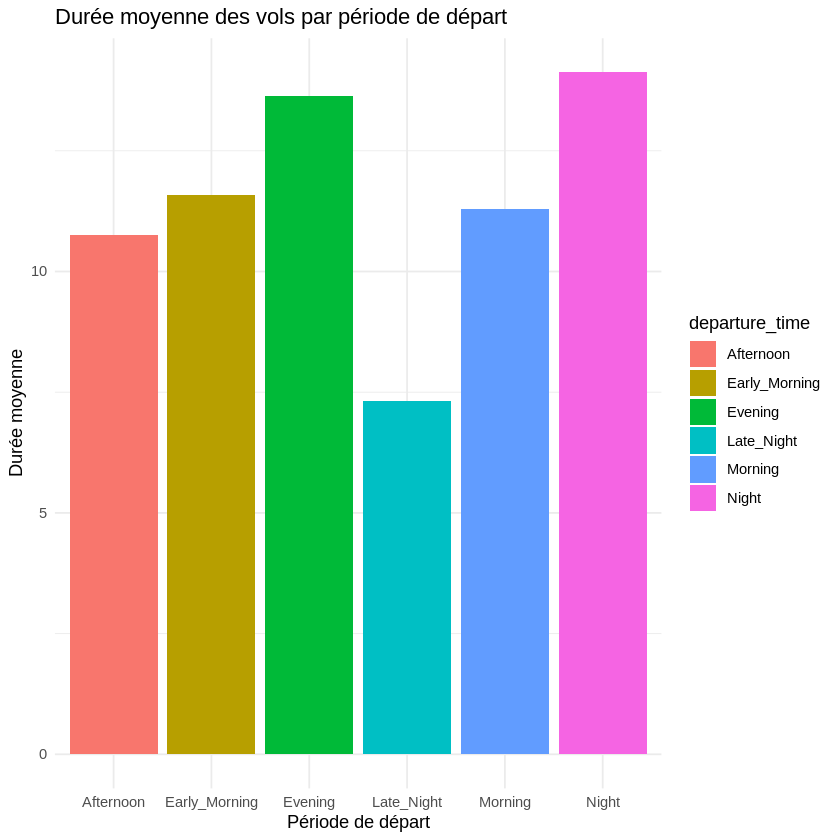

In [85]:
query3 <- "SELECT departure_time, AVG(duration) AS avg_duration FROM flights GROUP BY departure_time"
data3 <- dbGetQuery(con, query3)

num <- nrow(data3)
random_colors <- hue_pal()(num)

ggplot(data3, aes(x = departure_time, y = avg_duration,fill = departure_time)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = random_colors) +
  labs(title = "Durée moyenne des vols par période de départ",
       x = "Période de départ",
       y = "Durée moyenne") +
  theme_minimal()

Don't know how to automatically pick scale for object of type <integer64>.
Defaulting to continuous.


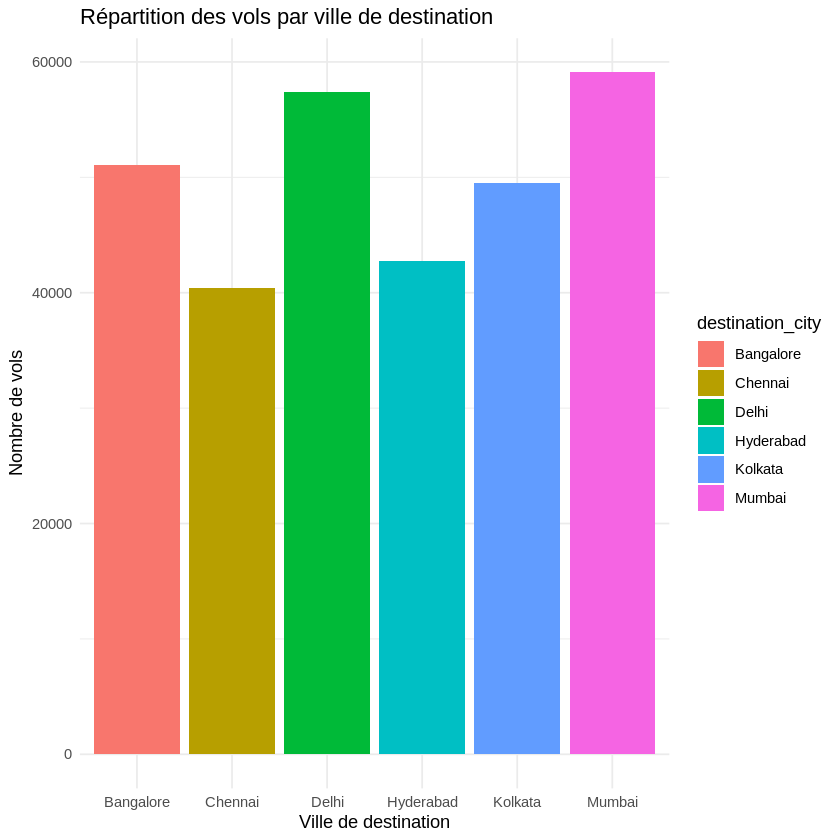

In [86]:
query4 <- "SELECT destination_city, COUNT(*) AS num_flights FROM flights GROUP BY destination_city"
data4 <- dbGetQuery(con, query4)

num <- nrow(data4)
random_colors <- hue_pal()(num)

ggplot(data4, aes(x = destination_city, y = num_flights,fill = destination_city )) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = random_colors) +
  labs(title = "Répartition des vols par ville de destination",
       x = "Ville de destination",
       y = "Nombre de vols") +
  theme_minimal()

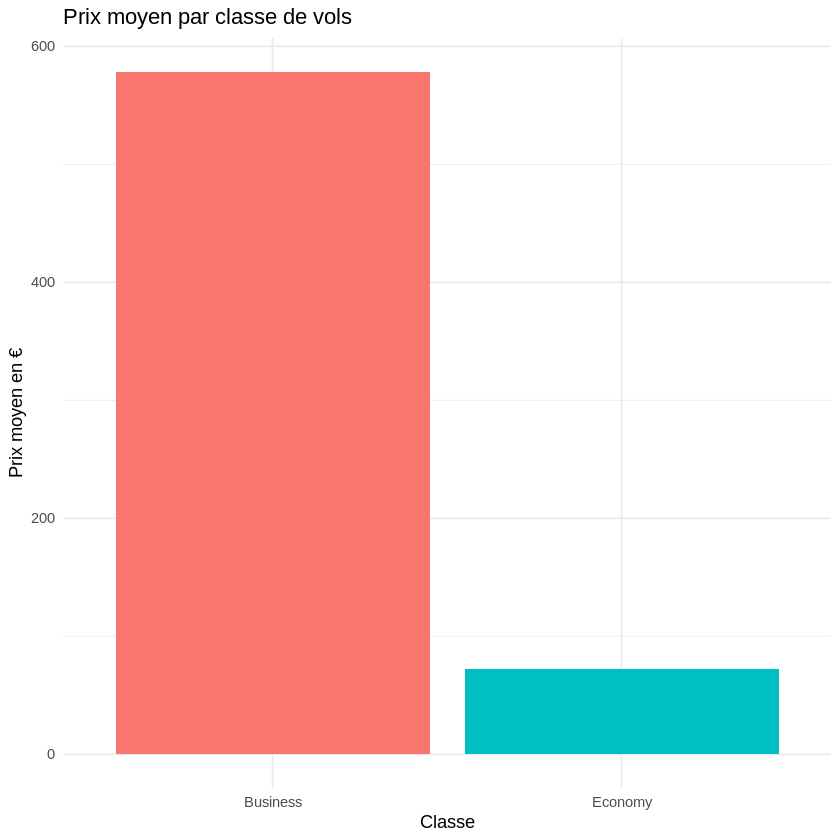

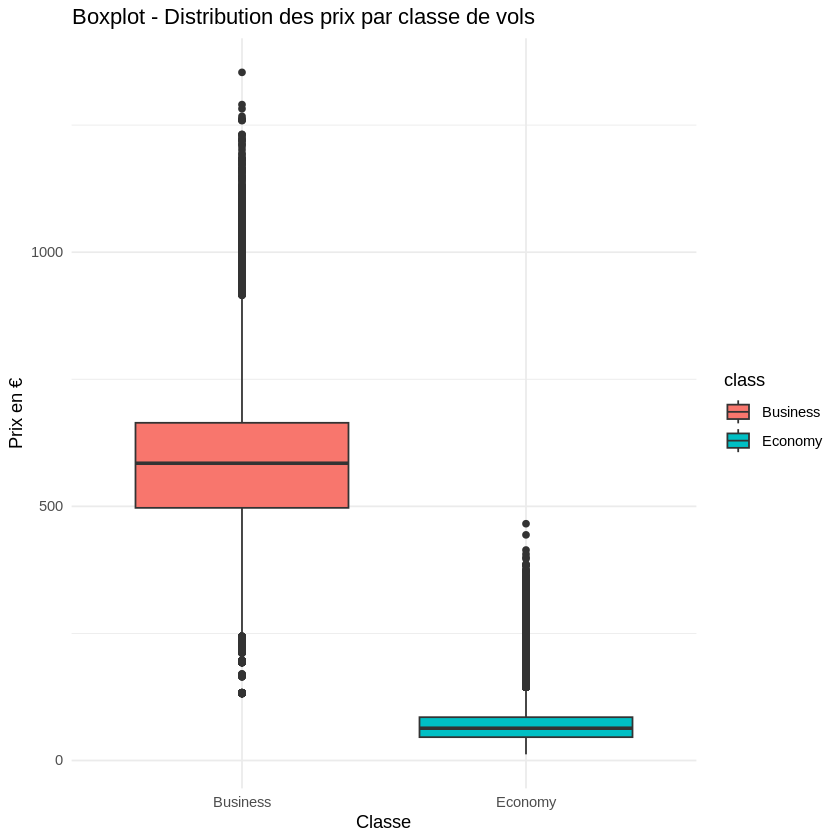

In [104]:
query5 <- "SELECT class, AVG(price_euro) AS avg_price FROM flights GROUP BY class"
data5 <- dbGetQuery(con, query5)

num <- nrow(data5)
random_colors <- hue_pal()(num)

ggplot(data5, aes(x = class, y = avg_price, fill = class)) +
  geom_bar(stat = "identity", show.legend = FALSE) +
  scale_fill_manual(values = random_colors) +
  labs(title = "Prix moyen par classe de vols",
       x = "Classe",
       y = "Prix moyen en €") +
  theme_minimal()

ggplot(flights, aes(x = class, y = price_euro, fill = class)) +
  geom_boxplot() +
  scale_fill_manual(values = random_colors) +
  labs(title = "Boxplot - Distribution des prix par classe de vols",
       x = "Classe",
       y = "Prix en €") +
  theme_minimal()

In [109]:
str(flights)

'data.frame':	300153 obs. of  20 variables:
 $ X                       : int  0 1 2 3 4 5 6 7 8 9 ...
 $ airline                 : chr  "SpiceJet" "SpiceJet" "AirAsia" "Vistara" ...
 $ flight                  : chr  "SG-8709" "SG-8157" "I5-764" "UK-995" ...
 $ source_city             : chr  "Delhi" "Delhi" "Delhi" "Delhi" ...
 $ departure_time          : chr  "Evening" "Early_Morning" "Early_Morning" "Morning" ...
 $ stops                   : chr  "zero" "zero" "zero" "zero" ...
 $ arrival_time            : chr  "Night" "Morning" "Early_Morning" "Afternoon" ...
 $ destination_city        : chr  "Mumbai" "Mumbai" "Mumbai" "Mumbai" ...
 $ class                   : chr  "Economy" "Economy" "Economy" "Economy" ...
 $ duration                : num  2.17 2.33 2.17 2.25 2.33 2.33 2.08 2.17 2.17 2.25 ...
 $ days_left               : int  1 1 1 1 1 1 1 1 1 1 ...
 $ price                   : int  5953 5953 5956 5955 5955 5955 6060 6060 5954 5954 ...
 $ departure_time_encoded  : num  4 1 1 2 2 2 

In [116]:
x <- flights %>%
  select(airline_encoded,class_encoded,departure_time_encoded,arrival_time_encoded,duration,stops_encoded,source_city_encoded,destination_city_encoded)

y <- flights %>%
  select(price_euro) %>%
  unlist()

In [117]:
str(y)

 Named num [1:300153] 65.5 65.5 65.5 65.5 65.5 ...
 - attr(*, "names")= chr [1:300153] "price_euro1" "price_euro2" "price_euro3" "price_euro4" ...


In [118]:
set.seed(42)  # Fixer la graine pour la reproductibilité
train_index <- createDataPartition(y, p = 0.7, list = FALSE)  # Indices de l'ensemble d'entraînement
x_train <- x[train_index, ]
x_test <- x[-train_index, ]
y_train <- y[train_index]
y_test <- y[-train_index]

In [119]:
# Check dims
dim(x_train)
dim(x_test)
length(y_train)
length(y_test)

[1] 210109      8

[1] 90044     8

[1] 210109

[1] 90044

Call:
rpart(formula = price_euro ~ ., data = cbind(x_train, price_euro = y_train), 
    method = "anova")
  n= 210109 

          CP nsplit  rel error     xerror         xstd
1 0.87922895      0 1.00000000 1.00000951 0.0027671751
2 0.03672262      1 0.12077105 0.12077768 0.0007446655
3 0.01000000      2 0.08404843 0.08405393 0.0005206626

Variable importance
class_encoded      duration stops_encoded 
           92             4             4 

Node number 1: 210109 observations,    complexity param=0.8792289
  mean=229.7093, MSE=62306.85 
  left son=2 (144681 obs) right son=3 (65428 obs)
  Primary splits:
      class_encoded        < 1.5  to the left,  improve=0.879228900, (0 missing)
      airline_encoded      < 5.5  to the left,  improve=0.129228300, (0 missing)
      duration             < 9.29 to the left,  improve=0.055359860, (0 missing)
      stops_encoded        < 1.5  to the left,  improve=0.034928350, (0 missing)
      arrival_time_encoded < 5.5  to the right, improve=0.00893

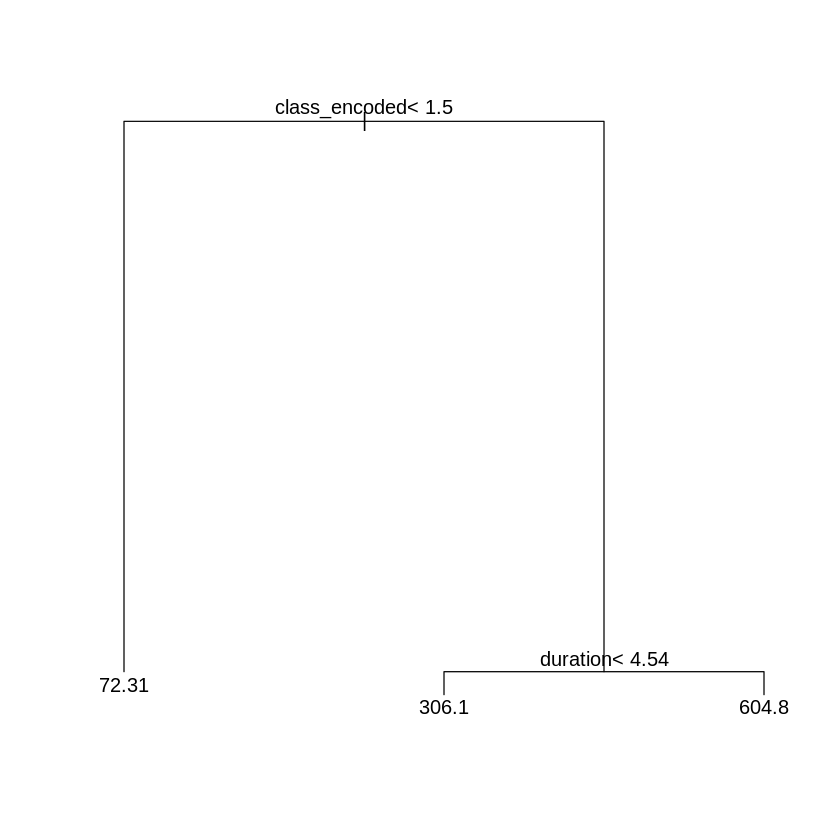

In [121]:
# Construire le modèle d'arbre de décision
model <- rpart(price_euro ~ ., data = cbind(x_train, price_euro = y_train), method = "anova")

# Afficher un résumé du modèle
summary(model)

# Visualiser l'arbre de décision (facultatif)
plot(model)
text(model, pretty = 1)


Call:
 randomForest(x = x_train, y = y_train, ntree = 100) 
               Type of random forest: regression
                     Number of trees: 100
No. of variables tried at each split: 2

          Mean of squared residuals: 2883.629
                    % Var explained: 95.37


,IncNodePurity
airline_encoded,1143702026
class_encoded,9920506360
departure_time_encoded,39018736
arrival_time_encoded,60854453
duration,428968782
stops_encoded,255427692
source_city_encoded,68597780
destination_city_encoded,71325050


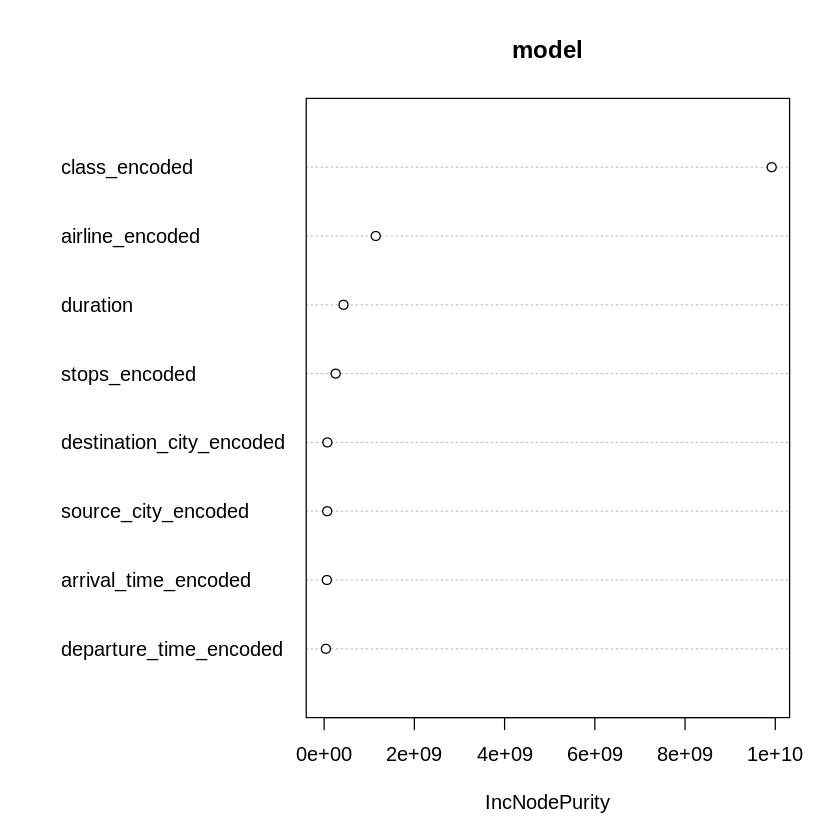

In [123]:
# Construire le modèle de forêt aléatoire
model <- randomForest(x = x_train, y = y_train, ntree = 100)

# Afficher un résumé du modèle
print(model)

# Vérifier l'importance des variables
importance(model)
varImpPlot(model)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


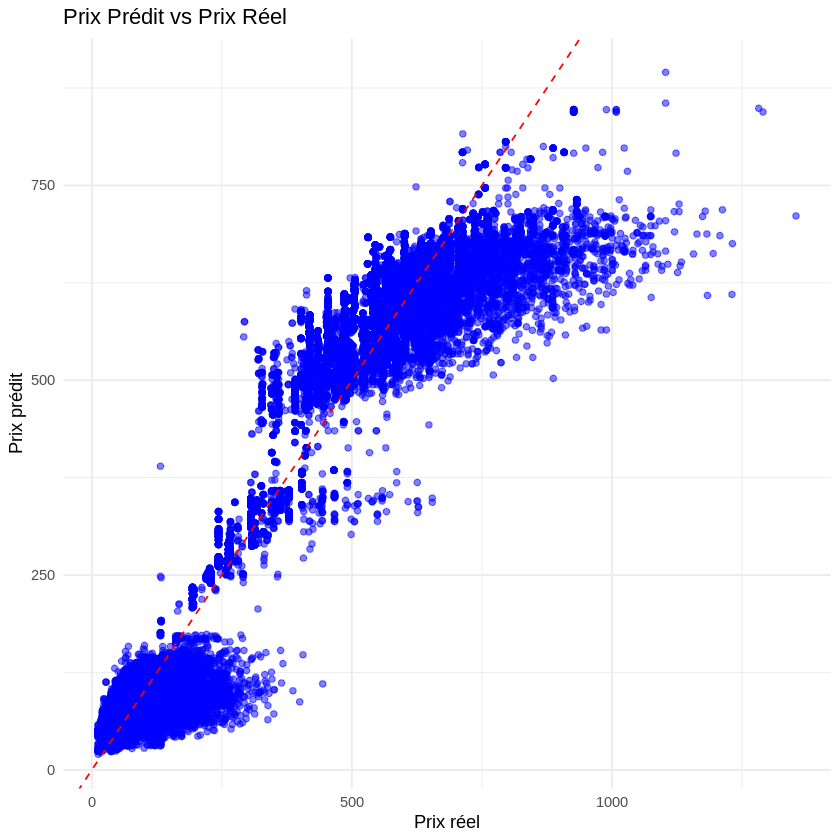

In [136]:
# Faire des prédictions sur l'ensemble de test
predictions <- predict(model, x_test)

results <- data.frame(Actual = y_test, Predicted = predictions)

ggplot(results, aes(x = Actual, y = Predicted)) +
  geom_point(color = 'blue', alpha = 0.5) +
  geom_abline(slope = 1, intercept = 0, color = 'red', linetype = 'dashed') +
  labs(title = "Prix Prédit vs Prix Réel",
       x = "Prix réel",
       y = "Prix prédit") +
  theme_minimal()

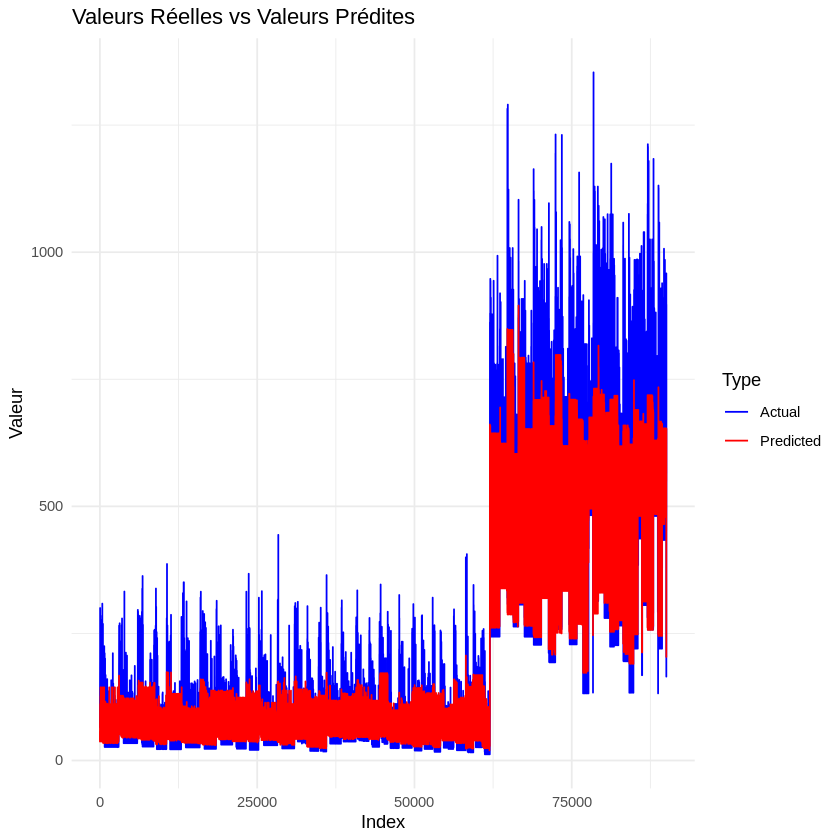

In [140]:
# Faire des prédictions sur l'ensemble de test
predictions <- predict(model, x_test)

# Créer un data frame avec les valeurs réelles et prédites
results <- data.frame(
  Index = seq_along(y_test),  # Index pour le traçage des lignes
  Actual = y_test,
  Predicted = predictions
)

results_long <- results %>%
  pivot_longer(cols = c(Actual, Predicted), names_to = "Type", values_to = "Value")

ggplot(results_long, aes(x = Index, y = Value, color = Type)) +
  geom_line() +
  labs(title = "Valeurs Réelles vs Valeurs Prédites",
       x = "Index",
       y = "Valeur",
       color = "Type") +
  theme_minimal() +
  scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red"))

In [128]:
rmse_value <- rmse(y_test, predictions)
mae_value <- mae(y_test, predictions)
r_squared <- cor(y_test, predictions)^2

# Afficher les métriques de performance
print(paste("RMSE:", rmse_value))
print(paste("MAE:", mae_value))
print(paste("R-squared:", r_squared))

[1] "RMSE: 53.1835072884852"
[1] "MAE: 36.3279417316688"
[1] "R-squared: 0.956553541923562"


In [131]:
# Sauvegarder le modèle
saveRDS(model, file = "random_forest_model.rds")

# Charger le modèle (pour vérifier)
loaded_model <- readRDS("random_forest_model.rds")

# Vérifier si le modèle chargé est le même que l'original
print(loaded_model)


Call:
 randomForest(x = x_train, y = y_train, ntree = 100) 
               Type of random forest: regression
                     Number of trees: 100
No. of variables tried at each split: 2

          Mean of squared residuals: 2883.629
                    % Var explained: 95.37


In [146]:
x2 <- flights %>%
  select(airline,class,departure_time,arrival_time,duration,stops,source_city,destination_city)

y2 <- flights %>%
  select(price_euro) %>%
  unlist()

In [147]:
set.seed(42)  # Fixer la graine pour la reproductibilité
train_index <- createDataPartition(y2, p = 0.7, list = FALSE)  # Indices de l'ensemble d'entraînement
x2_train <- x2[train_index, ]
x2_test <- x2[-train_index, ]
y2_train <- y2[train_index]
y2_test <- y2[-train_index]


Call:
 randomForest(x = x2_train, y = y2_train, ntree = 100) 
               Type of random forest: regression
                     Number of trees: 100
No. of variables tried at each split: 2

          Mean of squared residuals: 3057.537
                    % Var explained: 95.09


,IncNodePurity
airline,1046929356
class,9706051033
departure_time,43186862
arrival_time,51329491
duration,521530474
stops,243510655
source_city,68701498
destination_city,73257326


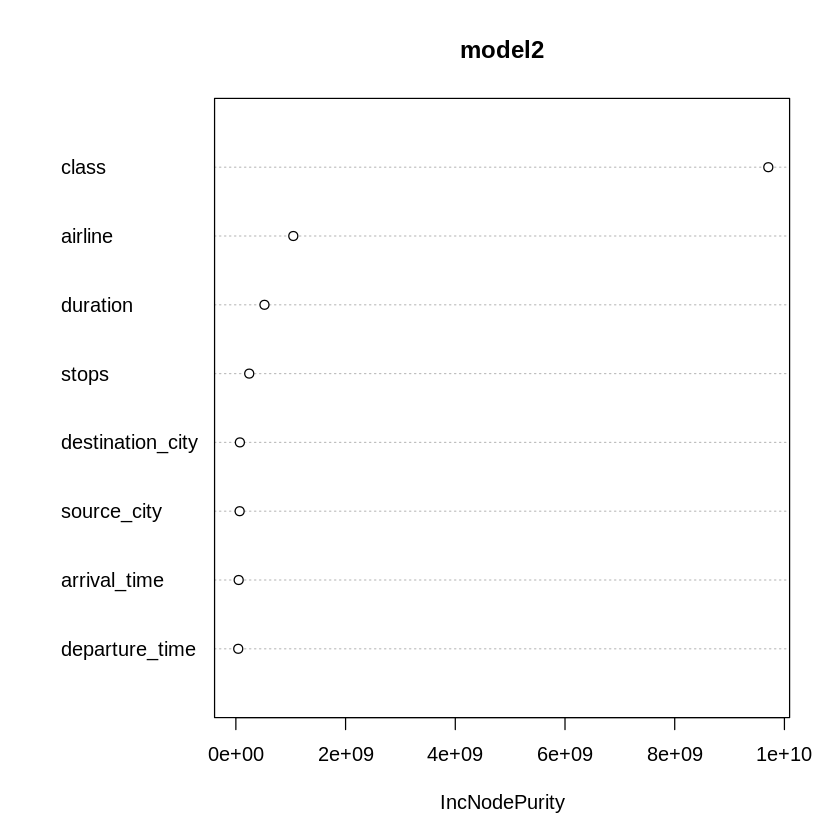

In [149]:
# Construire le modèle de forêt aléatoire
model2 <- randomForest(x = x2_train, y = y2_train, ntree = 100)

# Afficher un résumé du modèle
print(model2)

# Vérifier l'importance des variables
importance(model2)
varImpPlot(model2)

In [150]:
# Sauvegarder le modèle
saveRDS(model2, file = "random_forest_model2.rds")

# Charger le modèle (pour vérifier)
loaded_model2 <- readRDS("random_forest_model2.rds")

# Vérifier si le modèle chargé est le même que l'original
print(loaded_model2)


Call:
 randomForest(x = x2_train, y = y2_train, ntree = 100) 
               Type of random forest: regression
                     Number of trees: 100
No. of variables tried at each split: 2

          Mean of squared residuals: 3057.537
                    % Var explained: 95.09
